# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import time
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter


# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [5]:
data = pd.read_csv("Dataset/archive/loan_data.csv")

data.head(10)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## Pre-processing data

### Managing missing values 

In [7]:
data.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

Tidak ada data yang null

### Managing data duplicates

In [8]:
data.duplicated().sum()

np.int64(0)

Tidak ada duplikasi data

In [9]:
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


## Exploratory Data Analysis

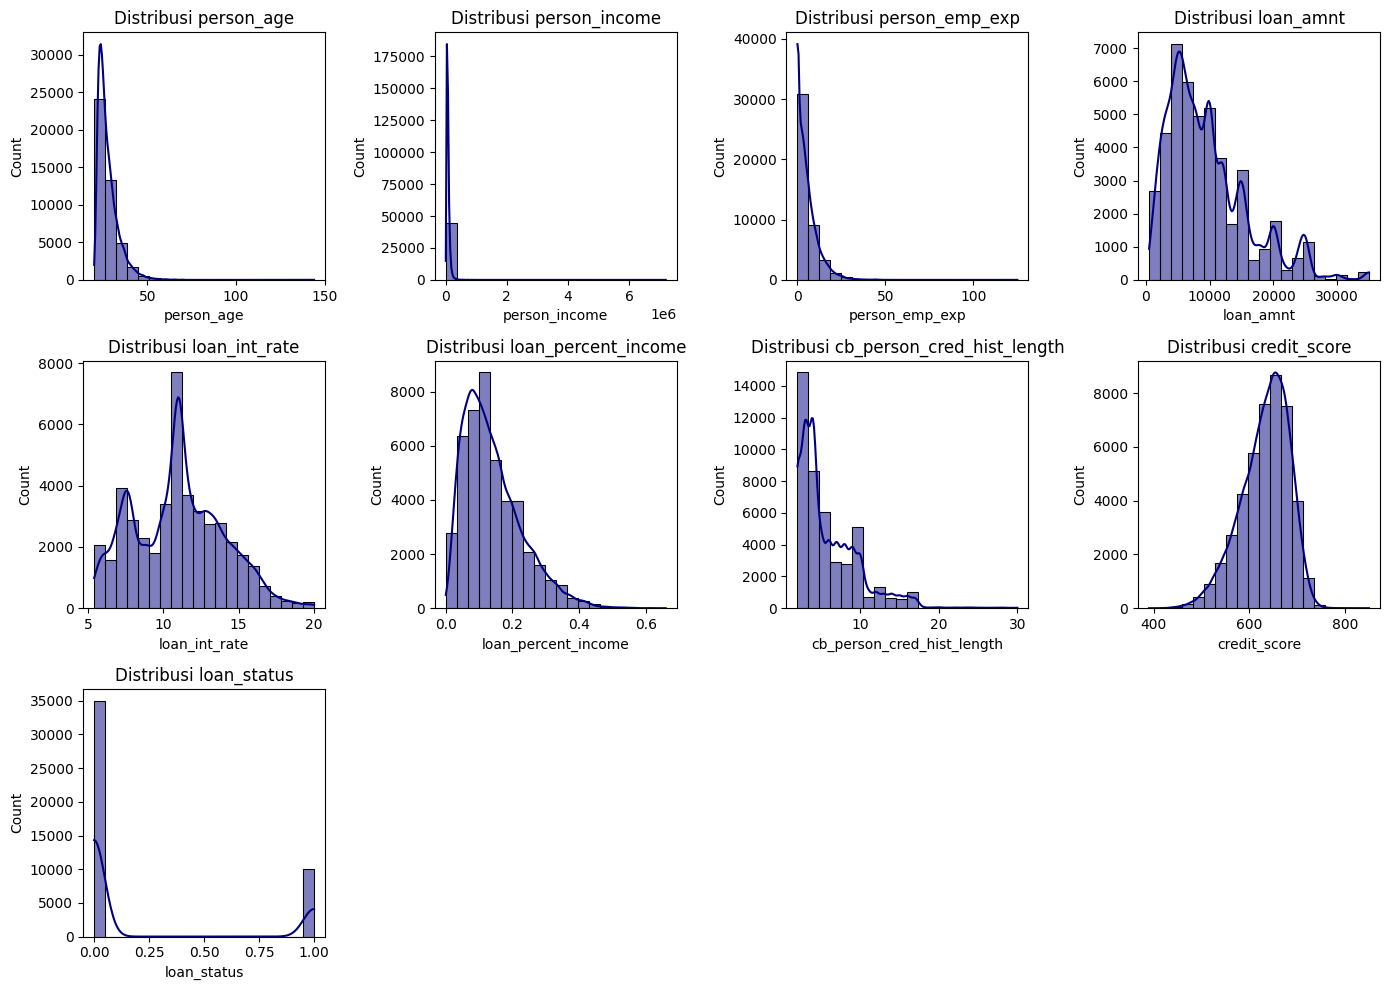

In [10]:
num_features = data.select_dtypes(include=[np.number])
plt.figure(figsize=(14,10))

for i, column in enumerate(num_features.columns, 1):
    plt.subplot(-(-1*len(num_features.columns)//4), 4, i)
    sns.histplot(data[column], bins=20, kde=True, color='navy')
    plt.title(f"Distribusi {column}")

plt.tight_layout()

plt.show()

Kebanyakan data menunjukkan right skewed distribution, sehingga kita akan melakukan normalisasi  setelah data splitting.

      person_gender  ... previous_loan_defaults_on_file
0            female  ...                             No
1            female  ...                            Yes
2            female  ...                             No
3            female  ...                             No
4              male  ...                             No
...             ...  ...                            ...
44995          male  ...                             No
44996        female  ...                             No
44997          male  ...                             No
44998          male  ...                             No
44999          male  ...                             No

[45000 rows x 5 columns]


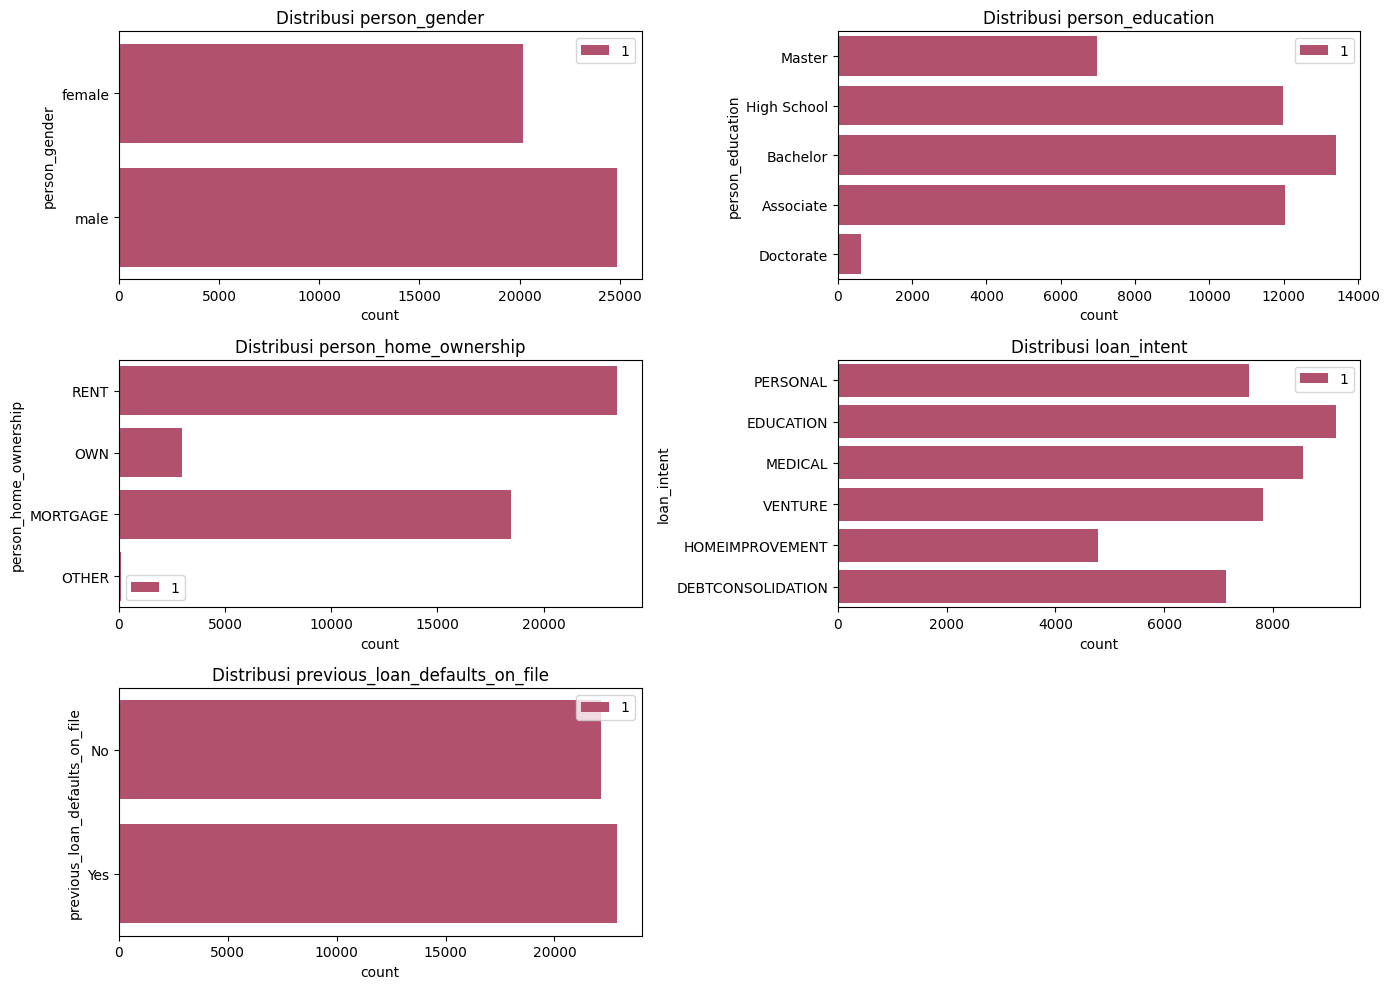

In [11]:
cat_features = data.select_dtypes(include=['object'])

print(cat_features)

plt.figure(figsize=(14,10))

for i, column in enumerate(cat_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=data[column], palette='flare', hue=1)
    plt.title(f"Distribusi {column}")

plt.tight_layout()
plt.show()

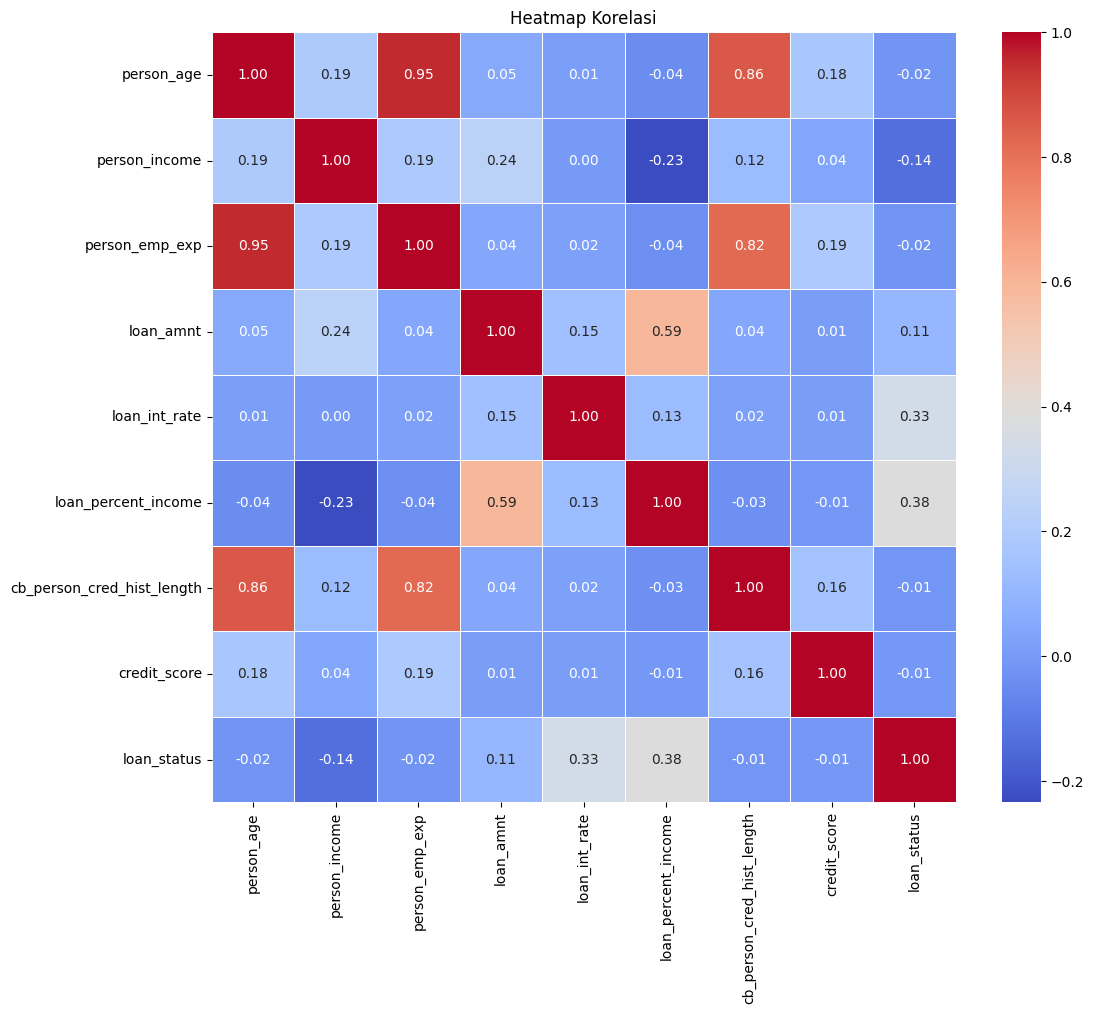

In [12]:
correlation_matrix = num_features.corr()

plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.7)
plt.title("Heatmap Korelasi")
plt.show()

In [13]:
print(correlation_matrix['loan_status'])

person_age                   -0.021476
person_income                -0.135808
person_emp_exp               -0.020481
loan_amnt                     0.107714
loan_int_rate                 0.332005
loan_percent_income           0.384880
cb_person_cred_hist_length   -0.014851
credit_score                 -0.007647
loan_status                   1.000000
Name: loan_status, dtype: float64


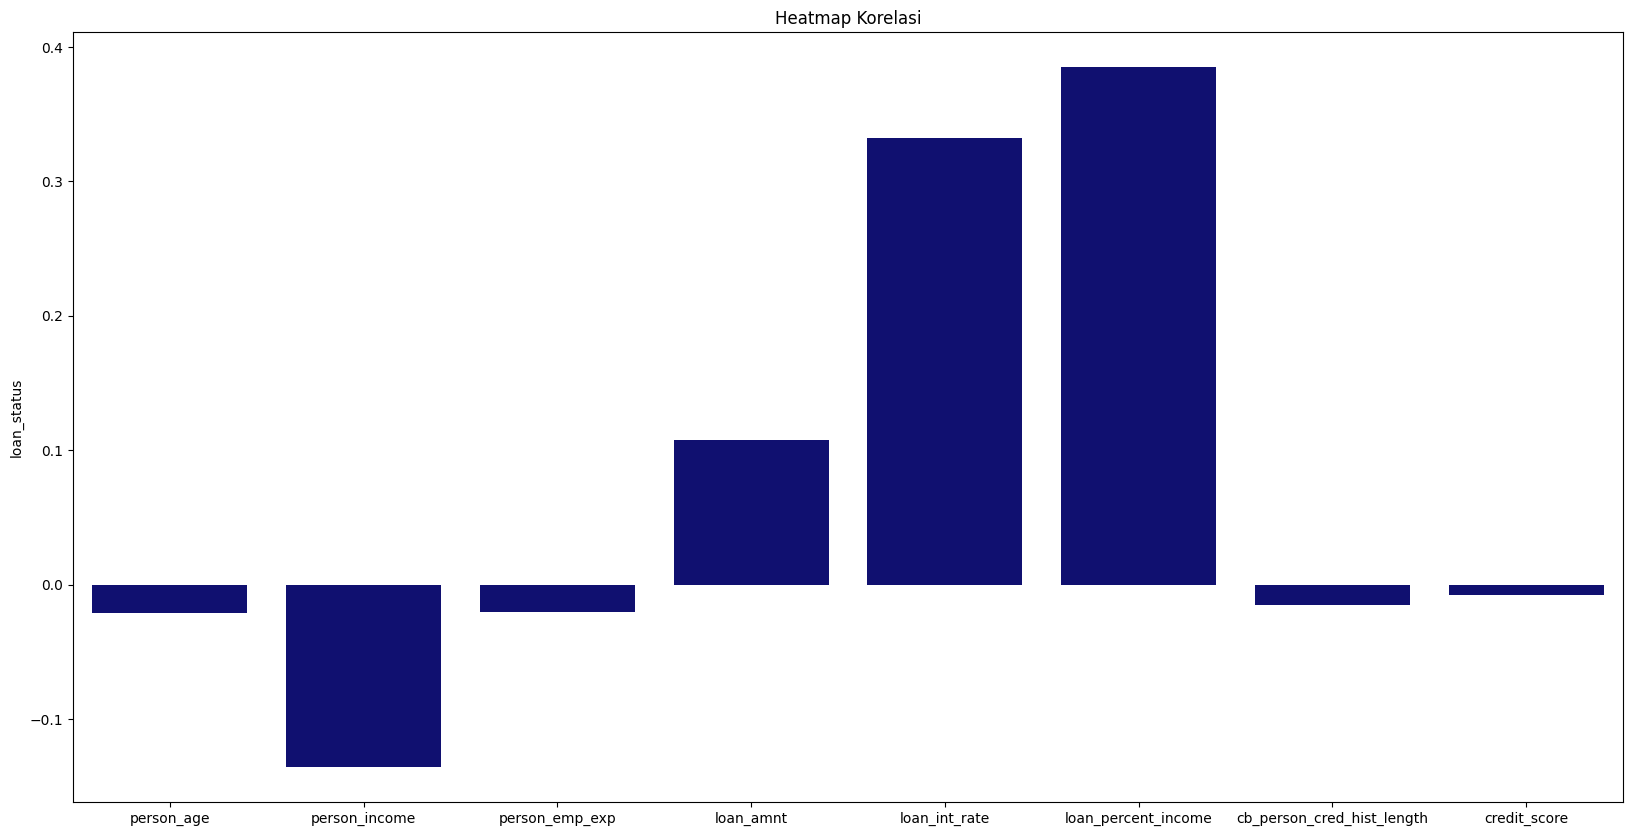

In [14]:
non_targeted_variables = data.drop(columns=['loan_status']).columns

# print(correlation_matrix['loan_status'][0])

plt.figure(figsize=(20,10))

sns.barplot(correlation_matrix['loan_status'][:8], color='navy')
plt.title("Heatmap Korelasi")
plt.show()

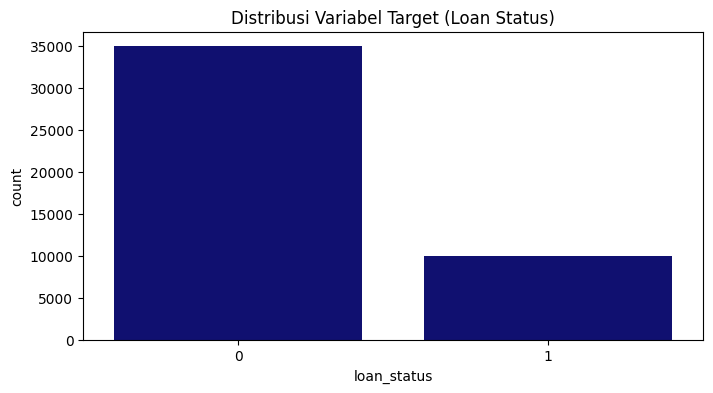

In [15]:
plt.figure(figsize=(8,4))

sns.countplot(x=data['loan_status'], color='navy')
plt.title('Distribusi Variabel Target (Loan Status)')
plt.show()


### Label Encoder

In [16]:
label_encoder = LabelEncoder()

for column in cat_features.columns:
    data[column] = label_encoder.fit_transform(data[column])

data.head(10)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,4,71948.0,0,3,35000.0,4,16.02,0.49,3.0,561,0,1
1,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.08,2.0,504,1,0
2,25.0,0,3,12438.0,3,0,5500.0,3,12.87,0.44,3.0,635,0,1
3,23.0,0,1,79753.0,0,3,35000.0,3,15.23,0.44,2.0,675,0,1
4,24.0,1,4,66135.0,1,3,35000.0,3,14.27,0.53,4.0,586,0,1
5,21.0,0,3,12951.0,0,2,2500.0,5,7.14,0.19,2.0,532,0,1
6,26.0,0,1,93471.0,1,3,35000.0,1,12.42,0.37,3.0,701,0,1
7,24.0,0,3,95550.0,5,3,35000.0,3,11.11,0.37,4.0,585,0,1
8,24.0,0,0,100684.0,3,3,35000.0,4,8.90,0.35,2.0,544,0,1
9,21.0,0,3,12739.0,0,2,1600.0,5,14.74,0.13,3.0,640,0,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [17]:
x = data.drop(columns=['loan_status'])
y = data['loan_status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


print(f"Training set shape: X_train={x_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={x_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(31500, 13), y_train=(31500,)
Test set shape: X_test=(13500, 13), y_test=(13500,)


Kemudian kita melakukan standarisasi. Pastikan standarisasi tidak membocorkan data test.

In [18]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [19]:
lr = LogisticRegression().fit(x_train, y_train)
dt = DecisionTreeClassifier().fit(x_train, y_train)
rf = RandomForestClassifier().fit(x_train, y_train)
knn = KNeighborsClassifier().fit(x_train, y_train)

Tulis narasi atau penjelasan algoritma yang Anda gunakan.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [20]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    results = {
        'confusion_matrix': cm,
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'True Negative (TN)': tn,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    return results

results = {
    'Logistic Regression (LR)': evaluate_model(lr, x_test, y_test),
    'Decision Tree (DT)' : evaluate_model(dt, x_test, y_test),
    'Random Forest (RF)' : evaluate_model(rf, x_test, y_test),
    'K-Nearest Neighbors (KNN)' : evaluate_model(knn, x_test, y_test)
}

summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
# print(results)

rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
        }
    )

summary_df = pd.DataFrame(rows)

summary_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression (LR),0.889111,0.759986,0.733954,0.746743
1,Decision Tree (DT),0.898000,0.766688,0.779182,0.772885
2,Random Forest (RF),0.923852,0.875237,0.767542,0.817860
3,K-Nearest Neighbors (KNN),0.889926,0.772483,0.716994,0.743705


Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

Berdasarkan hasil evaluasi di atas, saya memutuskan untuk menggunakan Random FOrest karena memiliki hasil yang paling baik.

==== Random Forest ====
Confusion Matrix:
[[10164   329]
 [  699  2308]]
True Positive (TP): 2308
False Positive (FP): 329
False Negative (FN): 699
True Negative (TN): 10164
Accuracy: 0.9239
Precision: 0.8752
Recall: 0.7675
F1-Score: 0.8179

----------------------------------------



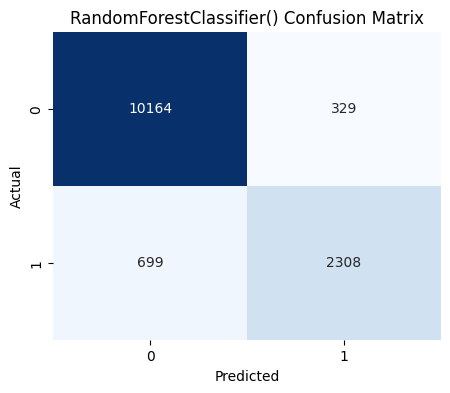

In [21]:
def show_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm_knn = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm_knn.ravel()
    print("==== Random Forest ====")
    print("Confusion Matrix:")
    print(cm_knn)
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("\n" + "-"*40 + "\n")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

show_evaluate(rf, x_test, y_test)
    

Model ini telah memprediksi sangat banyak data yang benar berdasarkan keseluruhan dataset (Accuracy) yaitu sebesar 92,48%.  Tidak hanya itu, model ini juga sudah baik dalam menghindari positif palsu (Precision) yaitu sebesar 87.7%. Dalam menangkap semua data positif, model ini cukup baik dengan tingkat Recall 77,05%.

F1-score yang sudah baik yaitu 82,03%.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [22]:
start_time = time.time()

param_space = {
    'n_estimators': (100, 500),
    'max_depth': (10, 100),
    'min_samples_split': (2,30),
    'min_samples_leaf': (1,10),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf_bayes = BayesSearchCV(estimator=rf, search_spaces=param_space, n_iter=32, cv=3, n_jobs=1, verbose=2, random_state=42)
rf_bayes.fit(x_train, y_train)


print(f"Best parameters (Bayesian Optimization): {rf_bayes.best_params_}")
best_rf_bayes = rf_bayes.best_estimator_

bayes_search_score = best_rf_bayes.score(x_test, y_test)
print(f"Accuracy after Bayesian Optimization: {bayes_search_score:.2f}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Waktu eksekusi: {execution_time:.4f} detik")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=94, min_samples_leaf=4, min_samples_split=21, n_estimators=266; total time=   6.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=94, min_samples_leaf=4, min_samples_split=21, n_estimators=266; total time=   6.9s
[CV] END bootstrap=True, criterion=entropy, max_depth=94, min_samples_leaf=4, min_samples_split=21, n_estimators=266; total time=   7.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=37, min_samples_leaf=10, min_samples_split=26, n_estimators=125; total time=   4.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=37, min_samples_leaf=10, min_samples_split=26, n_estimators=125; total time=   4.5s
[CV] END bootstrap=False, criterion=entropy, max_depth=37, min_samples_leaf=10, min_samples_split=26, n_estimators=125; total time=   4.0s
Fitting 3 folds for each of 1 candidates, totalling 3 

Best parameters (Bayesian Optimization): OrderedDict({'bootstrap': False, 'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 489})
Accuracy after Bayesian Optimization: 0.93
Waktu eksekusi: 937.7773 detik

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

Menggunakan Bayesian Optimization

==== Random Forest ====
Confusion Matrix:
[[10177   316]
 [  656  2351]]
True Positive (TP): 2351
False Positive (FP): 316
False Negative (FN): 656
True Negative (TN): 10177
Accuracy: 0.9280
Precision: 0.8815
Recall: 0.7818
F1-Score: 0.8287

----------------------------------------



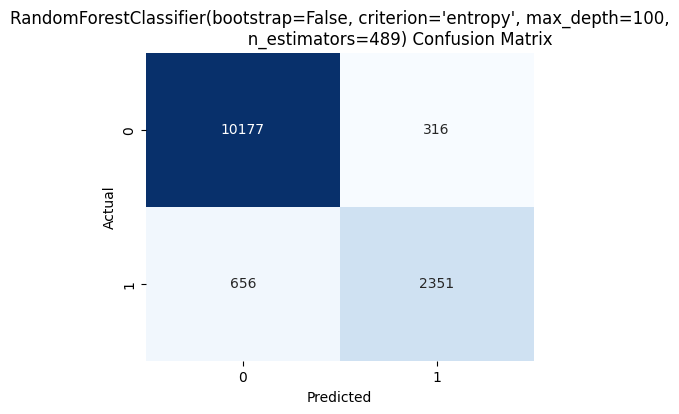

In [23]:
show_evaluate(best_rf_bayes, x_test, y_test)

==== Random Forest ====
Confusion Matrix:
[[10182   311]
 [  671  2336]]
True Positive (TP): 2336
False Positive (FP): 311
False Negative (FN): 671
True Negative (TN): 10182
Accuracy: 0.9273
Precision: 0.8825
Recall: 0.7769
F1-Score: 0.8263

----------------------------------------



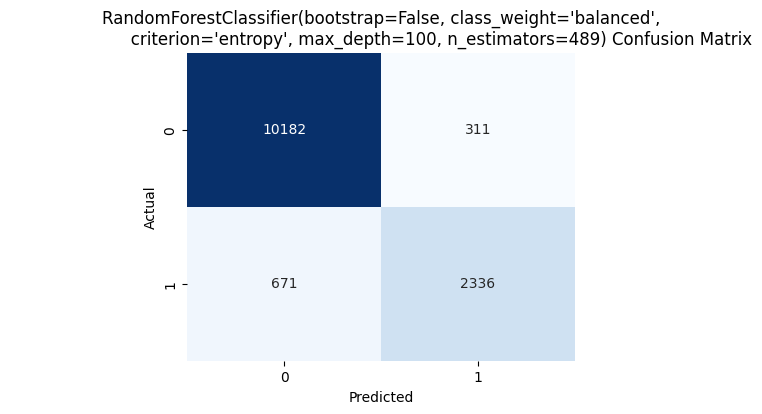

In [25]:
rf_2 = RandomForestClassifier(
    bootstrap=False,
    criterion='entropy',
    max_depth=100,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=489,
    class_weight='balanced'
).fit(x_train, y_train)

show_evaluate(rf_2, x_test, y_test)

In [30]:
data['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

Recall masih cukup rendah karena ketidak seimbangan data antara y positif dan y negatif. Maka langkah selanjutnya saya akan mencoba mengatasinya dengan salah satu metode oversampling yaitu SMOTE.

In [42]:
x2 = data.drop(columns=['loan_status'])
y2 = data['loan_status']

print("Distribusi kelas sebelum SMOTE:", Counter(y))

Distribusi kelas sebelum SMOTE: Counter({0: 35000, 1: 10000})


In [43]:
smote = SMOTE(random_state=42)

x_resampled, y_resampled = smote.fit_resample(x2, y2)

print("Distribusi kelas sebelum SMOTE:", Counter(y_resampled))

Distribusi kelas sebelum SMOTE: Counter({1: 35000, 0: 35000})


In [46]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_resampled, y_resampled)

print(f"Training set shape: X_train={x_train2.shape}, y_train={y_train2.shape}")
print(f"Test set shape: X_test={x_test2.shape}, y_test={y_test2.shape}")

Training set shape: X_train=(52500, 13), y_train=(52500,)
Test set shape: X_test=(17500, 13), y_test=(17500,)


==== Random Forest ====
Confusion Matrix:
[[8081  645]
 [ 413 8361]]
True Positive (TP): 8361
False Positive (FP): 645
False Negative (FN): 413
True Negative (TN): 8081
Accuracy: 0.9395
Precision: 0.9284
Recall: 0.9529
F1-Score: 0.9405

----------------------------------------



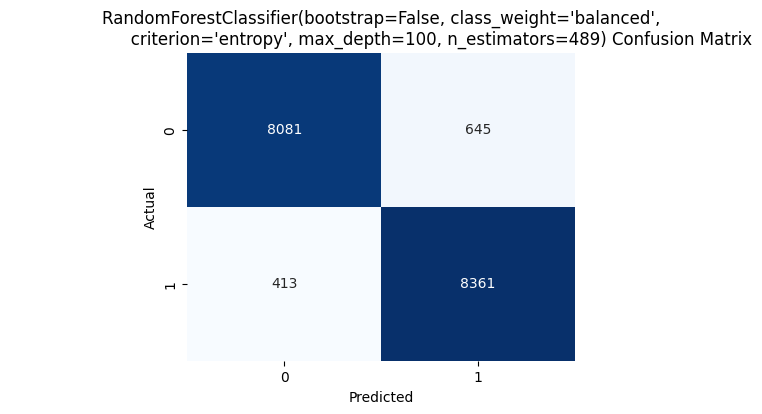

In [47]:
rf_3 = RandomForestClassifier(
    bootstrap=False,
    criterion='entropy',
    max_depth=100,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=489,
    class_weight='balanced'
).fit(x_train2, y_train2)

show_evaluate(rf_3, x_test2, y_test2)

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

1. Hasil evaluasi sebelum tuning adalah:
==== Random Forest ====

Confusion Matrix:

[[10164   329]

 [  699  2308]]

True Positive (TP): 2308

False Positive (FP): 329

False Negative (FN): 699

True Negative (TN): 10164

Accuracy: 0.9239

Precision: 0.8752

Recall: 0.7675

F1-Score: 0.8179

----------------------------------------

Sedangkan hasil evaluasi setelah tuning dan SMOTE adalah:

==== Random Forest ====

Confusion Matrix:

[[8081  645]

 [ 413 8361]]

True Positive (TP): 8361

False Positive (FP): 645

False Negative (FN): 413

True Negative (TN): 8081

Accuracy: 0.9395

Precision: 0.9284

Recall: 0.9529

F1-Score: 0.9405

----------------------------------------

Terdapat perubahan yang sangat signifikan terutama dalam Precision, Recall, dan F1-Score.

2. Preceision dan Recall sudah sangat tinggi.

Analisis underfitting / overfitting

In [48]:
y_train_pred = rf_3.predict(x_train2)
y_test_pred = rf_3.predict(x_test2)

train_acc = accuracy_score(y_train2, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Training Accuracy: 1.0
Test Accuracy: 0.9395428571428571


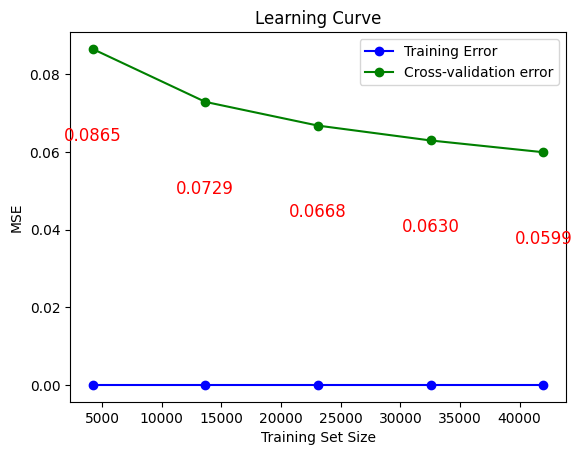

In [50]:
train_sizes, train_scores, test_scores = learning_curve(rf_3, x_train2, y_train2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean,'o-', color='blue', label='Training Error')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation error')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")

for i in range(len(train_sizes)):
    plt.text(train_sizes[i], test_mean[i]-0.02, f'{test_mean[i]:.4f}', color='red',fontsize=12, ha='center', va='top')

plt.legend()
plt.show()

Skor evaluasi pada data train dan data test sudah sangat baik, sehingga tidak menunjukkan model mengalami underfit atau overfit.

3. Rekomendasi tingkat lanjutan tidak diperlukan karena hasilnya telah memuaskan.